See [proof_of_concept_specinterp.ipynb](proof_of_concept_specinterp.ipynb) for why this is used.

In [1]:
import re
import collections
from pathlib import Path

import multiprocess
from tqdm.notebook import tqdm

import numpy as np

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import Distance
from astropy import table
from astropy import nddata

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
phoenix_data = Path('phoenix/subgrid')
while not phoenix_data.is_dir():
    phoenix_data = phoenix_data.parent
assert phoenix_data != Path(), 'no part of this path is present!'
phoenix_data

PosixPath('phoenix')

In [4]:
wavepth = list(phoenix_data.glob('*WAVE*'))
assert len(wavepth) == 1
wavepth = wavepth[0]

In [5]:
pattern = re.compile('lte(\d{5})([+-][0-9.]{4})([+-][0-9.]{3}).PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

PhoenixFiles = collections.namedtuple('PhoenixFiles', 'pth, teff, logg, fehish'.split(', '))

matches = []
for p in phoenix_data.iterdir():
    if m := pattern.match(p.name):
        matches.append(PhoenixFiles(p, int(m.group(1)), -float(m.group(2)), float(m.group(3))))
    
matches[0]

PhoenixFiles(pth=PosixPath('phoenix/lte08400-4.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'), teff=8400, logg=4.5, fehish=-0.5)

In [6]:
with fits.open(wavepth) as f:
    phoenix_wave = f[0].data << u.Unit(f[0].header['UNIT'])
phoenix_wave

<Quantity [  500.  ,   500.1 ,   500.2 , ..., 54999.25, 54999.5 , 54999.75] Angstrom>

# Get the filter definition files

In [7]:
base_filter_url = 'http://svo2.cab.inta-csic.es/theory/fps/fps.php?PhotCalID={filter}/{system}'

st_filters = """
HST/ACS_WFC.F475W
HST/ACS_WFC.F555W
HST/ACS_WFC.F606W
HST/ACS_WFC.F814W
JWST/NIRCam.F070W
JWST/NIRCam.F090W
JWST/NIRCam.F115W
JWST/NIRCam.F150W
JWST/NIRCam.F200W
""".strip().split()
sdss_filters = ['SLOAN/SDSS.'+b for b in 'ugriz']
general_filters = ['Generic/Johnson.'+b for b in 'BVRI']

filtersets = []
for f in st_filters:
    filtersets.append((f, 'Vega' if f.startswith('HST') else 'AB'))  # note this is *not* 'ST' for ST mag
for f in sdss_filters:
    filtersets.append((f, 'AB'))
for f in general_filters:
    filtersets.append((f, 'Vega'))

filtersets

[('HST/ACS_WFC.F475W', 'Vega'),
 ('HST/ACS_WFC.F555W', 'Vega'),
 ('HST/ACS_WFC.F606W', 'Vega'),
 ('HST/ACS_WFC.F814W', 'Vega'),
 ('JWST/NIRCam.F070W', 'AB'),
 ('JWST/NIRCam.F090W', 'AB'),
 ('JWST/NIRCam.F115W', 'AB'),
 ('JWST/NIRCam.F150W', 'AB'),
 ('JWST/NIRCam.F200W', 'AB'),
 ('SLOAN/SDSS.u', 'AB'),
 ('SLOAN/SDSS.g', 'AB'),
 ('SLOAN/SDSS.r', 'AB'),
 ('SLOAN/SDSS.i', 'AB'),
 ('SLOAN/SDSS.z', 'AB'),
 ('Generic/Johnson.B', 'Vega'),
 ('Generic/Johnson.V', 'Vega'),
 ('Generic/Johnson.R', 'Vega'),
 ('Generic/Johnson.I', 'Vega')]

In [8]:
filter_tables = {}
for f,s in filtersets:
    url = base_filter_url.format(filter=f, system=s)
    
    filter_tables[f+'/'+s] = table.QTable.read(url, cache=True)
filter_tables.keys(), next(iter(filter_tables.values()))

(dict_keys(['HST/ACS_WFC.F475W/Vega', 'HST/ACS_WFC.F555W/Vega', 'HST/ACS_WFC.F606W/Vega', 'HST/ACS_WFC.F814W/Vega', 'JWST/NIRCam.F070W/AB', 'JWST/NIRCam.F090W/AB', 'JWST/NIRCam.F115W/AB', 'JWST/NIRCam.F150W/AB', 'JWST/NIRCam.F200W/AB', 'SLOAN/SDSS.u/AB', 'SLOAN/SDSS.g/AB', 'SLOAN/SDSS.r/AB', 'SLOAN/SDSS.i/AB', 'SLOAN/SDSS.z/AB', 'Generic/Johnson.B/Vega', 'Generic/Johnson.V/Vega', 'Generic/Johnson.R/Vega', 'Generic/Johnson.I/Vega']),
 <QTable length=1979>
 Wavelength Transmission
     AA                 
  float64     float64   
 ---------- ------------
     3797.0  7.86814e-05
     3798.0  8.83984e-05
     3799.0  9.81664e-05
     3800.0  0.000107984
     3801.0  0.000117739
     3802.0  0.000127525
     3803.0  0.000137344
     3804.0  0.000147194
     3805.0  0.000157077
     3806.0  0.000166992
     3807.0  0.000176939
     3808.0  0.000186919
     3809.0  0.000196931
        ...          ...
     5762.0  0.000102829
     5763.0  0.000100612
     5764.0  9.83942e-05
     5765.0  9.6

Try just one before parallelizing

In [9]:
test_idx = 12
with fits.open(matches[test_idx][0]) as f:
    test_phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=f[0].data*u.Unit(f[0].header['BUNIT']))
matches[test_idx]

PhoenixFiles(pth=PosixPath('phoenix/lte05500-5.50-1.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'), teff=5500, logg=5.5, fehish=-1.5)

In [10]:
filter_table = filter_tables['SLOAN/SDSS.r/AB']

standard_flux = Spectrum1D(flux=[1]*len(filter_table)*u.Jy, spectral_axis=filter_table['Wavelength']).with_flux_unit(test_phoenix_spec.flux.unit).flux

resampler = FluxConservingResampler()
resampled = resampler.resample1d(test_phoenix_spec, filter_table['Wavelength'])

In [11]:
dlamb = np.diff(resampled.spectral_axis)
ddlamb = np.insert(dlamb, 0, np.mean(dlamb))
assert len(ddlamb) == len(resampled.spectral_axis)

In [12]:
numerator = resampled.flux*filter_table['Transmission'] * resampled.spectral_axis
denominator = standard_flux*filter_table['Transmission'] * resampled.spectral_axis
float(np.sum(numerator*ddlamb)/np.sum(denominator*ddlamb))

7.121639286658084e+18

Doesn't seem crazy. Set up utility functions now in prep for parallelization

In [13]:
def filter_fluxes_ab(model_spec, filter_table):
    resampler = FluxConservingResampler()
    resampled = resampler.resample1d(model_spec, filter_table['Wavelength'])
    
    ddlamb = np.diff(resampled.spectral_axis.bin_edges)
    
    ab_standard_flux = Spectrum1D(flux=[3631]*len(filter_table)*u.Jy, spectral_axis=filter_table['Wavelength']).with_flux_unit(test_phoenix_spec.flux.unit).flux
    
    numerator = resampled.flux*filter_table['Transmission'] * resampled.spectral_axis
    denominator = ab_standard_flux*filter_table['Transmission'] * resampled.spectral_axis

    return float(np.sum(numerator*ddlamb)/np.sum(denominator*ddlamb))

-2.5*np.log10(filter_fluxes_ab(test_phoenix_spec, filter_tables['SLOAN/SDSS.r/AB'])/filter_fluxes_ab(test_phoenix_spec, filter_tables['SLOAN/SDSS.z/AB']))

0.24168594392072443

Need to pick a vega spectrum.

In [14]:
vega_mod_url = 'https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/alpha_lyr_mod_004.fits'
vega_stis_url = 'https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/alpha_lyr_stis_011.fits'

In [15]:
f1=fits.open(vega_mod_url)
f2=fits.open(vega_stis_url)

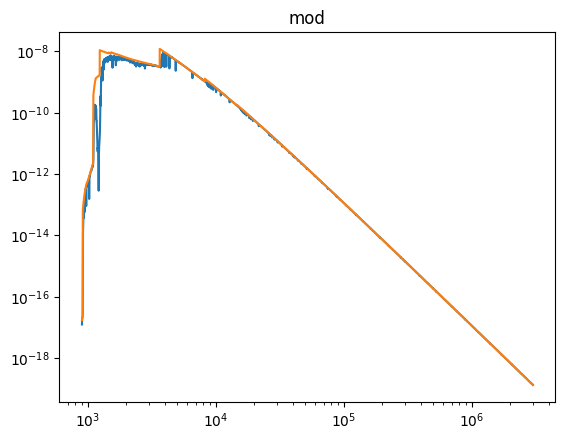

In [16]:
plt.loglog(f1[1].data['WAVELENGTH'], f1[1].data['FLUX'])
plt.loglog(f1[1].data['WAVELENGTH'], f1[1].data['CONTINUUM'])
plt.title('mod');

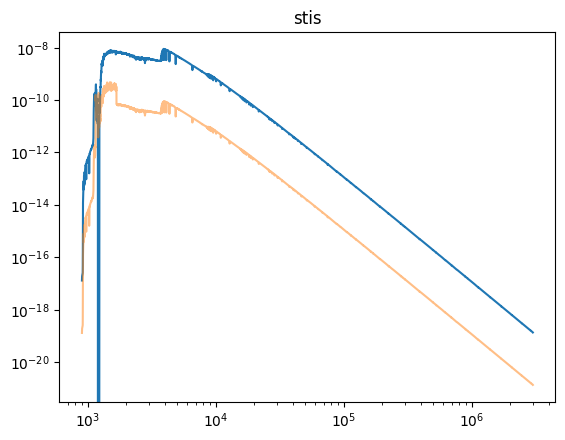

In [17]:
err = np.hypot(f2[1].data['STATERROR'], f2[1].data['SYSERROR'])

plt.loglog(f2[1].data['WAVELENGTH'], f2[1].data['FLUX'])

plt.loglog(f2[1].data['WAVELENGTH'], err, alpha=.5)
plt.title('stis');

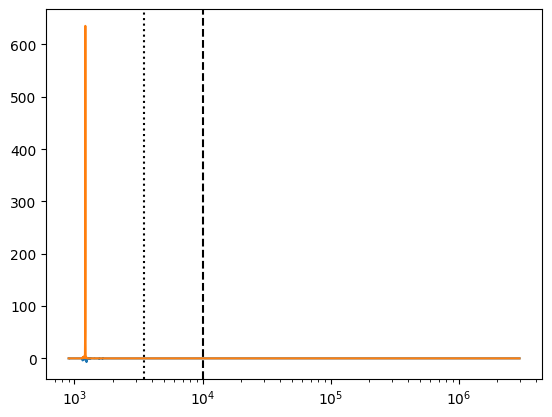

In [18]:
mod = Spectrum1D(spectral_axis=f1[1].data['WAVELENGTH']*u.angstrom, flux=f1[1].data['FLUX']*u.erg / u.s * u.cm**-2 / u.angstrom)
mod_to_stiswl = FluxConservingResampler().resample1d(mod, f2[1].data['WAVELENGTH']*u.angstrom)
plt.semilogx(mod_to_stiswl.spectral_axis, (mod_to_stiswl.flux.value - f2[1].data['FLUX'])/mod_to_stiswl.flux.value);
plt.semilogx(mod_to_stiswl.spectral_axis, err/mod_to_stiswl.flux.value);
plt.axvline(3500, c='k', ls=':')
plt.axvline(10000, c='k', ls='--')
fig = plt.gcf()
ax = plt.gca()

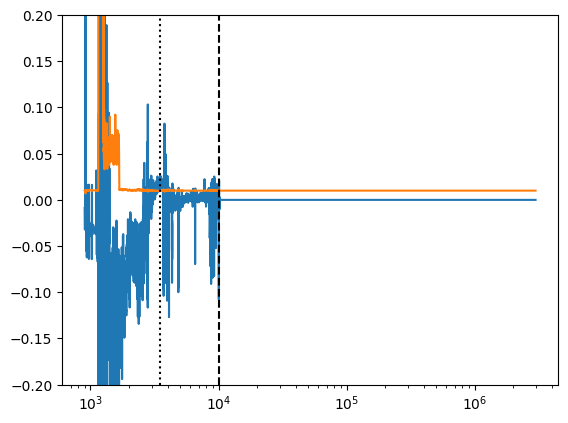

In [19]:
ax.set_ylim(-.2,.2)
fig

Basically the same, but lets use STIS for "consistency with actual definitions"

In [20]:
vega_spectrum_tbl = table.Table.read(vega_stis_url, cache=True)
wl = vega_spectrum_tbl['WAVELENGTH'].value << u.angstrom
fx = vega_spectrum_tbl['FLUX'].value << (u.erg / u.s * u.cm**-2 / u.angstrom)
err = nddata.StdDevUncertainty(np.hypot(vega_spectrum_tbl['STATERROR'].value, vega_spectrum_tbl['SYSERROR'].value) << fx.unit)

vega_spectrum = Spectrum1D(spectral_axis=wl, flux=fx, uncertainty=err)

In [21]:
def filter_fluxes_vega(model_spec, filter_table):
    resampler = FluxConservingResampler()
    resampled = resampler.resample1d(model_spec, filter_table['Wavelength'])
    
    dlamb = np.diff(resampled.spectral_axis)
    ddlamb = np.insert(dlamb, 0, np.mean(dlamb))

    vega_standard_flux = resampler.resample1d(vega_spectrum, filter_table['Wavelength']).flux
    
    numerator = resampled.flux*filter_table['Transmission'] * resampled.spectral_axis
    denominator = vega_standard_flux*filter_table['Transmission'] * resampled.spectral_axis

    return float(np.sum(numerator*ddlamb)/np.sum(denominator*ddlamb))
    
-2.5*np.log10(filter_fluxes_vega(test_phoenix_spec, filter_tables['HST/ACS_WFC.F814W/Vega'])/filter_fluxes_vega(test_phoenix_spec, filter_tables['JWST/NIRCam.F115W/AB']))

0.40965918755697583

These seem like plausible colors.  Lets carry through with something that will compute for the full set

In [22]:
def model_spectrum_fluxes(model_spec_pth, doraise=False):
    try:
        outpath = Path(str(model_spec_pth).split('.PHOENIX')[0] + '.fluxes')
        if outpath.is_file():
            fluxes = eval(outpath.open().read())
            return (fluxes, 'exists:' + str(outpath))
        
        with fits.open(model_spec_pth) as f:
            model_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=f[0].data*u.Unit(f[0].header['BUNIT']))
        fluxes = {}
        for fnm, filter_table in filter_tables.items():
            psys = fnm.split('/')[-1]
            if psys == 'Vega':
                flux = filter_fluxes_vega(model_spec, filter_table)
            elif psys == 'AB':
                flux = filter_fluxes_ab(model_spec, filter_table)
            else:
                raise ValueError(f'unrecognized photometric system {psys}')
            fluxes[fnm] = flux

        with outpath.open('w') as f:
            f.write(str(fluxes))
        
        return (fluxes, str(outpath))
    except Exception as e:
        if doraise:
            raise
        return (None, str(e))

#test run, but takes a while so no need to repeat
#model_spectrum_fluxes(matches[test_idx][0])

In [23]:
pool = multiprocess.Pool()

mres = pool.map_async(model_spectrum_fluxes, (m[0] for m in matches))

This could take many hours to compute the first time through, although it's almost instantaneous.  So we have async run monitoring here.  (You can close the notebook, come back later, and just re-run the cell below the pbar to update it.)

In [24]:
pbar = tqdm(total=len(matches))

  0%|          | 0/7559 [00:00<?, ?it/s]

In [25]:
import time
time.sleep(3)  # give it a bit of time for if all exist

In [26]:
n = len(list(Path('phoenix').glob('*fluxes')))  # this only records the *successful* ones.
if n > pbar.n:
    pbar.update(n - pbar.n)

rdy = mres.ready()
if rdy:
    res = mres.get()

    # clean up the pool so it doesn't give spurious errors later.
    pool.terminate()
    pool.join()
    pool.close()
    
rdy

True

Examine any errors

In [27]:
[(m[0],r[1]) for r,m in zip(res, matches) if r[0] is None]

[(PosixPath('phoenix/lte05500-1.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'),
  '"Keyword \'BUNIT\' not found."'),
 (PosixPath('phoenix/lte05200-0.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'),
  '"Keyword \'BUNIT\' not found."'),
 (PosixPath('phoenix/lte05100-0.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'),
  '"Keyword \'BUNIT\' not found."'),
 (PosixPath('phoenix/lte02800-1.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'),
  '"Keyword \'BUNIT\' not found."'),
 (PosixPath('phoenix/lte06800-6.00-1.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'),
  '"Keyword \'BUNIT\' not found."'),
 (PosixPath('phoenix/lte05800-1.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'),
  '"Keyword \'BUNIT\' not found."'),
 (PosixPath('phoenix/lte05900-1.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'),
  '"Keyword \'BUNIT\' not found."'),
 (PosixPath('phoenix/lte10800-5.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'),
  '"Keyword \'BUNIT\' not found."'),
 (PosixPath('phoenix/lte04600-0.00-4.0.PHOENIX-ACES-AGSS

In [28]:
fbad = fits.open('phoenix/lte05000-0.00-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
fgood = fits.open(matches[42][0])

fbad, fgood 

([<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7df779f3e1d0>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7df779f3fad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7df779f49c90>])

In [29]:
fbad[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =              1569128 / length of data axis 1                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
WAVE    = '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'                         
PHXTEFF =               5000.0 / [K] effective temperature                      
PHXLOGG =                  0.0 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                 -4.0 / [M/H] metallicity (rel. sol. - Asplund &a 2009)
PHXALPHA=                  0.0 / [a/M] alpha element enhancement                
DATE    = '2013-04-03 13:41:

In [30]:
fgood[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =              1569128                                                  
EXTEND  =                    T                                                  
EXTNAME = 'PRIMARY '                                                            
WAVE    = '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits' / Wavelength array      
PHXTEFF =               2500.0 / [K] effective temperature                      
PHXLOGG =                  1.0 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                 -2.0 / [M/H] metallicity (rel. sol. - Asplund &a 2009)
PHXALPHA=                  0.0 / [a/M] alpha element enhancement                
PHXDUST =                    F / Dust in atmosphere                             
PHXEOS  = 'ACES    '        

For unclear reasons, a *few* of them are missing the meta information about elements, BUNIT, etc. but that's fine we just ignore those since they will be missing critical other information anyway.

Now we re-jigger these into arrays of input and output features.

In [31]:
paths = []
features = {}
fluxes = {}
for f in matches[0]._fields[1:]:
    features[f] = []

for fnm in filter_tables.keys():
    fluxes[fnm] = []

for r,m in zip(res, matches):
    if r[0] is not None:
        paths.append(m.pth)
        for f in matches[0]._fields[1:]:
            features[f].append(getattr(m, f))

        for fnm in filter_tables.keys():
            fluxes[fnm].append(r[0][fnm])

paths = np.array(paths, dtype=object)
for dct in (features, fluxes):
    for k,v in dct.items():
        dct[k] = np.array(v)

features.keys(), fluxes.keys(), len(next(iter(features.values()))), len(next(iter(fluxes.values())))

(dict_keys(['teff', 'logg', 'fehish']),
 dict_keys(['HST/ACS_WFC.F475W/Vega', 'HST/ACS_WFC.F555W/Vega', 'HST/ACS_WFC.F606W/Vega', 'HST/ACS_WFC.F814W/Vega', 'JWST/NIRCam.F070W/AB', 'JWST/NIRCam.F090W/AB', 'JWST/NIRCam.F115W/AB', 'JWST/NIRCam.F150W/AB', 'JWST/NIRCam.F200W/AB', 'SLOAN/SDSS.u/AB', 'SLOAN/SDSS.g/AB', 'SLOAN/SDSS.r/AB', 'SLOAN/SDSS.i/AB', 'SLOAN/SDSS.z/AB', 'Generic/Johnson.B/Vega', 'Generic/Johnson.V/Vega', 'Generic/Johnson.R/Vega', 'Generic/Johnson.I/Vega']),
 7508,
 7508)

As a sanity check, pick a sun-like star for photometry tests

In [32]:
msk = (features['teff'] == 5800)&(features['logg'] == 4.5)&(features['fehish'] == 0)
assert np.sum(msk) == 1
-2.5*np.log(fluxes['Generic/Johnson.V/Vega'][msk])

array([-88.52691395])

Clearly we need some normalization... not surprising since they are actually SBs

In [33]:
hdr = fits.getheader(paths[msk][0], hdu=0)
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =              1569128                                                  
EXTEND  =                    T                                                  
EXTNAME = 'PRIMARY '                                                            
WAVE    = '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits' / Wavelength array      
PHXTEFF =               5800.0 / [K] effective temperature                      
PHXLOGG =                  4.5 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                  0.0 / [M/H] metallicity (rel. sol. - Asplund &a 2009)
PHXALPHA=                  0.0 / [a/M] alpha element enhancement                
PHXDUST =                    F / Dust in atmosphere                             
PHXEOS  = 'ACES    '        

In [34]:
total_V_lum = (fluxes['Generic/Johnson.V/Vega'][msk] * ((hdr['PHXREFF']*u.cm)**2 / (10*u.pc)**2).decompose())
total_V_lum, -2.5*np.log10(total_V_lum)

(<Quantity [0.01065192]>, <Quantity [4.93143054]>)

In [35]:
total_r_lum = (fluxes['SLOAN/SDSS.r/AB'][msk] * ((hdr['PHXREFF']*u.cm)**2 / (10*u.pc)**2).decompose())
total_r_lum, -2.5*np.log10(total_r_lum)

(<Quantity [0.01206879]>, <Quantity [4.79584059]>)

Huzzah!  Those are close to the expected answer.

Gather up all the REffs.  Note, though, this is slow for I/O reasons.  Parallelize to speed it up.

In [36]:
with multiprocess.Pool(64) as pool:
    reffs = np.fromiter(tqdm(pool.imap(lambda pth: fits.getval(pth, 'PHXREFF'), paths), total=len(paths)), dtype=float) << u.cm

  0%|          | 0/7508 [00:00<?, ?it/s]

In [37]:
distance = 10*u.pc
absmags = {k:-2.5*(np.log10(f) + 2 * np.log10(reffs/distance)) for k, f in fluxes.items()}

# should be ~4.8 since it's a sun-ish star
absmags['Generic/Johnson.V/Vega'][msk]

<Quantity [4.93143054]>

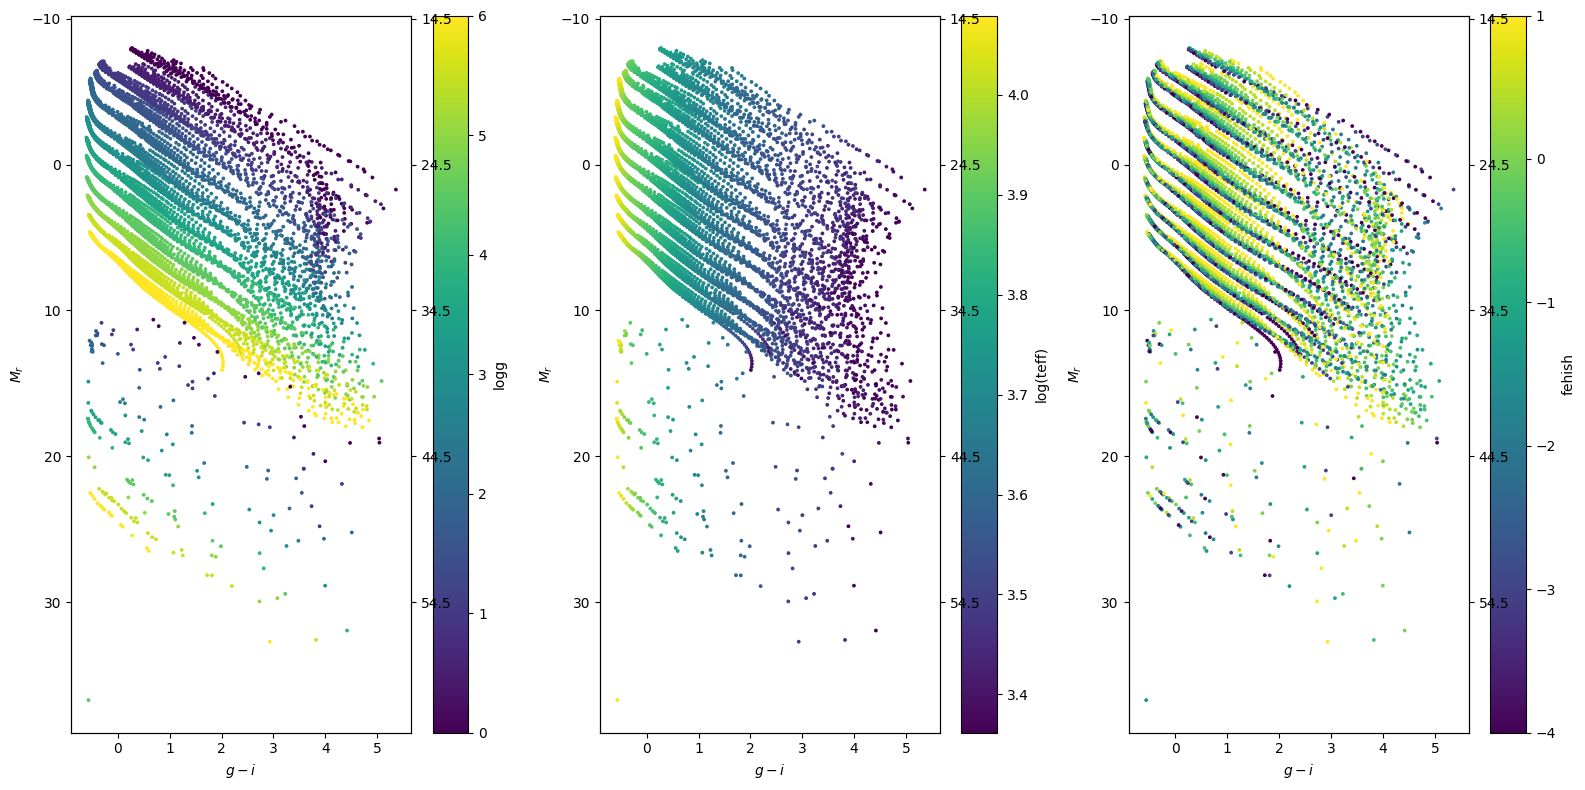

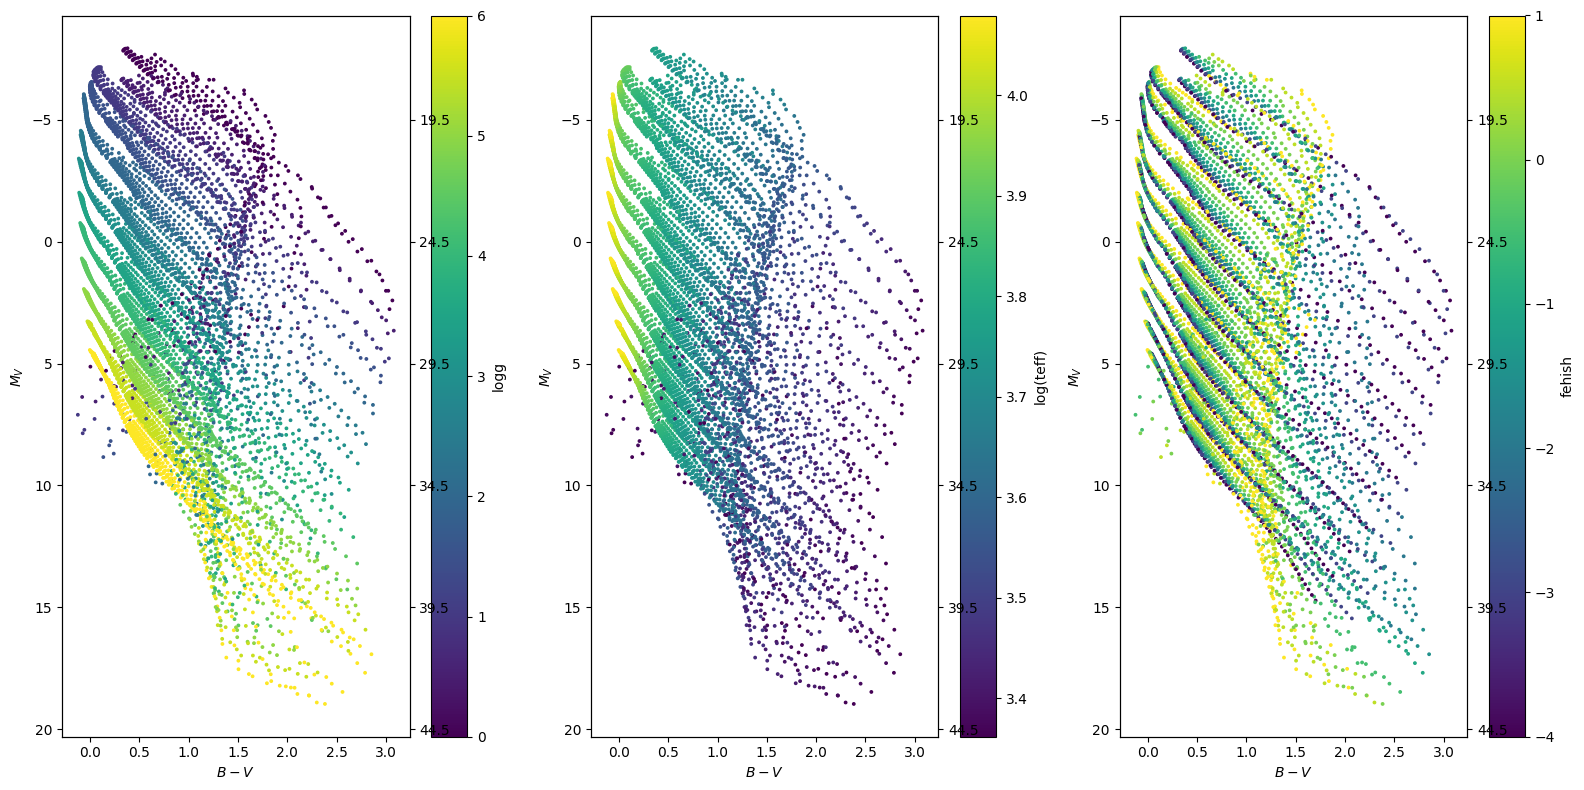

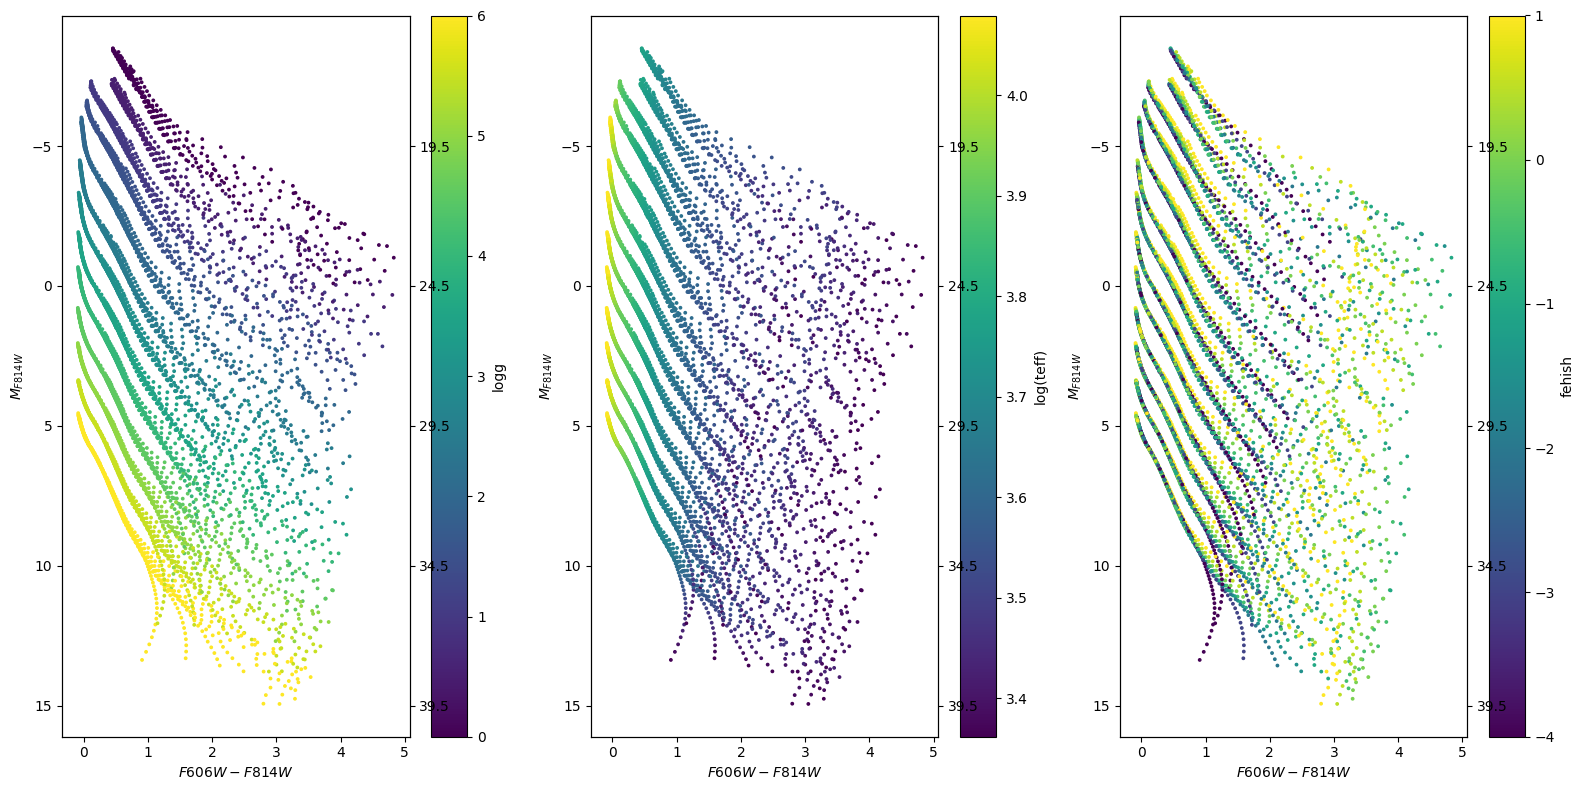

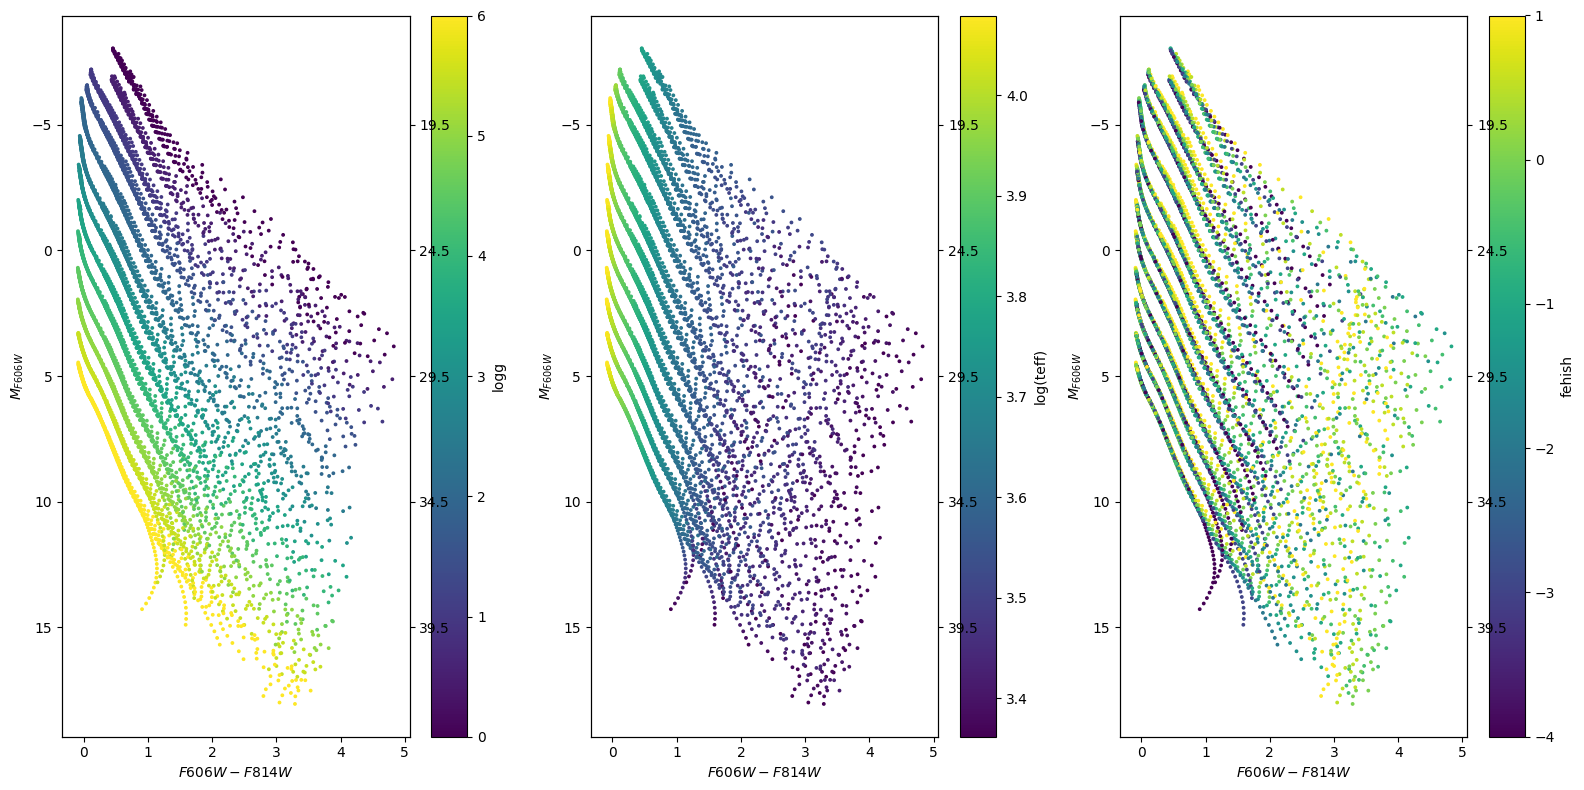

In [38]:
right_side_distance = Distance(780*u.kpc)

for c1, c2, m in [('SLOAN/SDSS.g/AB', 'SLOAN/SDSS.i/AB', 'SLOAN/SDSS.r/AB'),
                  ('Generic/Johnson.B/Vega', 'Generic/Johnson.V/Vega', 'Generic/Johnson.V/Vega'),
                  ('HST/ACS_WFC.F606W/Vega', 'HST/ACS_WFC.F814W/Vega', 'HST/ACS_WFC.F814W/Vega'),
                  ('HST/ACS_WFC.F606W/Vega', 'HST/ACS_WFC.F814W/Vega', 'HST/ACS_WFC.F606W/Vega'),
                 ]:

    c1label = c1.split('/')[-2].split('.')[-1]
    c2label = c2.split('/')[-2].split('.')[-1]
    mlabel =m.split('/')[-2].split('.')[-1]
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 8))
    for ax, cnm in zip(axs.ravel(), ['logg', 'teff', 'fehish']):
        c = features[cnm]
        if cnm in ('teff'):
            c = np.log10(c)
            clabel = f'log({cnm})'
        else:
            clabel = cnm
            
        sc = ax.scatter(absmags[c1]-absmags[c2], absmags[m], s=3, c=c)
        ax.set_xlabel(f'${c1label}-{c2label}$')
        ax.set_ylabel('$M_{'+mlabel+'}$')
        yl = ax.get_ylim()[::-1]
        ax.set_ylim(*yl)
        plt.colorbar(sc).set_label(clabel)
        
        tax = ax.twinx()
        tax.set_ylim(*yl)
        yt = tax.get_yticks()
        tax.set_yticks(yt, [f'{yi:.1f}' for yi in yt + right_side_distance.distmod.value])
        tax.set_ylim(*yl)
        
    fig.tight_layout()

### Cuda/torch preliminaries

In [39]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [40]:
for nm in 'cpu,cuda,cudnn,mps,mkl,mkldnn,openmp'.split(','):
    be = getattr(torch.backends, nm)
    built = be.is_built() if hasattr(be, 'is_built') else None
    avail = be.is_available() if hasattr(be, 'is_available') else None
    if avail is None and nm == 'cuda':
        avail = torch.cuda.is_available()
    print(nm, built, avail) 

torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

cpu None None
cuda True True
cudnn None True
mps False False
mkl None True
mkldnn None True
openmp None True
Using cuda device


In [41]:
def dconvert32(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=torch.float32)
def dconvert64(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=torch.float64)

# Model for training

In [42]:
class LayeredNN(nn.Module):
    def __init__(self, inn, outn, neurons_per_layer=[32], activation=nn.GELU):
        super().__init__()

        stack = []
        nneurons = neurons_per_layer.copy()
        lastn = inn
        while len(nneurons) > 0:
            n = nneurons.pop()
            stack.append(nn.Linear(lastn, n))
            stack.append(activation())
            lastn = n
        stack.append(nn.Linear(lastn, outn))
        
        self.primary_stack = nn.Sequential(*stack)

    def forward(self, x):
        return self.primary_stack(x)
    
LayeredNN(3, 4)

LayeredNN(
  (primary_stack): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)

lets take the log of teff to get everything in the ballpark of unity

In [65]:
mod_features = {}
for k, v in features.items():
    if k in ('teff'):
        mod_features['log'+k] = np.log10(v)
    else:
        mod_features[k] = v
mod_features.keys()

dict_keys(['logteff', 'logg', 'fehish'])

In [148]:
validation_fraction = .3
seed = 42

perm_idxs = np.random.default_rng(seed).permutation(len(next(iter(features.values()))))
valid_idxs = perm_idxs[:int(np.round(validation_fraction*n))]
train_idxs = perm_idxs[int(np.round(validation_fraction*n)):]
len(valid_idxs) + len(train_idxs), len(perm_idxs)

in_tensors = dconvert32(np.array(list(mod_features.values())).T)
out_tensors = dconvert32(np.array(list(absmags.values())).T)

validation_ins = in_tensors[valid_idxs]
validation_outs = out_tensors[valid_idxs]

In [228]:
n_batches = 15000
valid_period = 250

batch_fraction = .5
batch_size = int(np.round(len(train_idxs)*batch_fraction))

r = np.random.default_rng(seed)

model = LayeredNN(len(features), len(fluxes), neurons_per_layer=[128, 64, 32, 16]).to(torch_device)

model.train()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.3)

batchi_validation = []
loss_validation = []
last_lr = -1
lr_changes = []
for batchi in (t:=tqdm(list(range(n_batches)))):
    data_idxs = train_idxs[r.permutation(len(train_idxs))[:batch_size]]

    ins = in_tensors[data_idxs]
    outs = out_tensors[data_idxs]
        
    # Compute prediction error
    pred = model(ins)
    loss = loss_fn(pred, outs)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batchi % valid_period == 0 or batchi == (n_batches-1):
        with torch.no_grad():
            model.eval()
            batchi_validation.append(batchi)
            loss_validation.append(loss_fn(model(validation_ins), validation_outs).item())

            if last_lr == -1: # this disables the scheduler, effectively
                scheduler.step(loss_validation[-1])

            if last_lr != scheduler.get_last_lr()[0]:
                last_lr = scheduler.get_last_lr()[0]
                lr_changes.append((batchi, last_lr))

            t.set_description(f'test loss at batch {batchi} is {loss_validation[-1]}, lr: {last_lr}')
            t.update()
            
        model.train()

model.eval()

  0%|          | 0/15000 [00:00<?, ?it/s]

LayeredNN(
  (primary_stack): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=18, bias=True)
  )
)

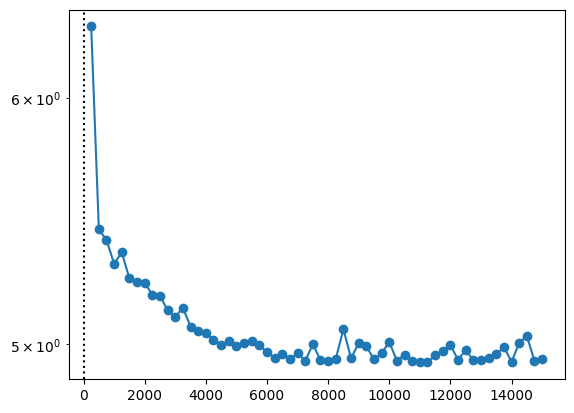

In [229]:
starti=1
plt.semilogy(batchi_validation[starti:], loss_validation[starti:], '-o')
for i, lr in lr_changes:
    plt.axvline(i, c='k', ls=':')

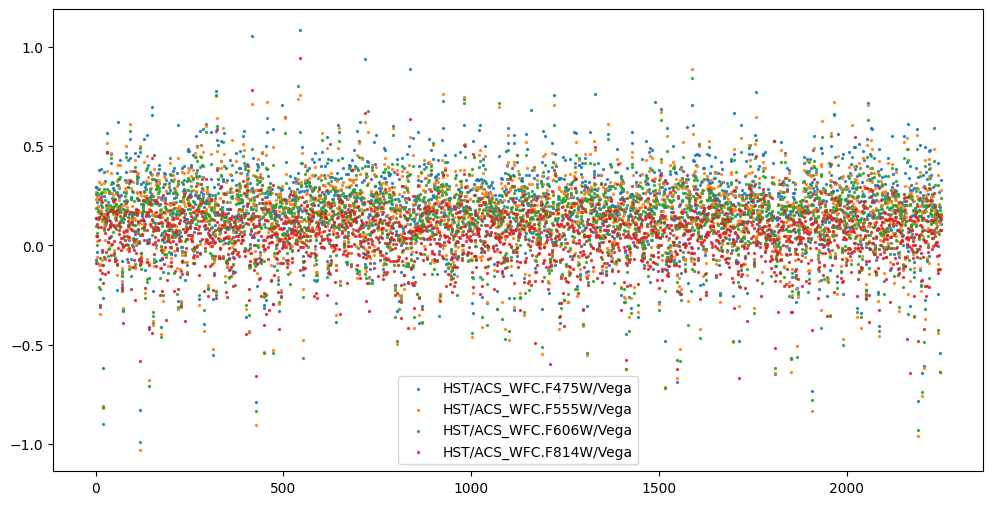

In [230]:
plt.figure(figsize=(12, 6))

residuals = (model(validation_ins) - validation_outs).detach().cpu().numpy()
for i in range(residuals.shape[-1]):
    if list(absmags.keys())[i].startswith('HST'):
        plt.scatter(np.arange(residuals.shape[0]), residuals[:, i], label=list(absmags.keys())[i], s=2, alpha=.8)

plt.legend(loc=0);

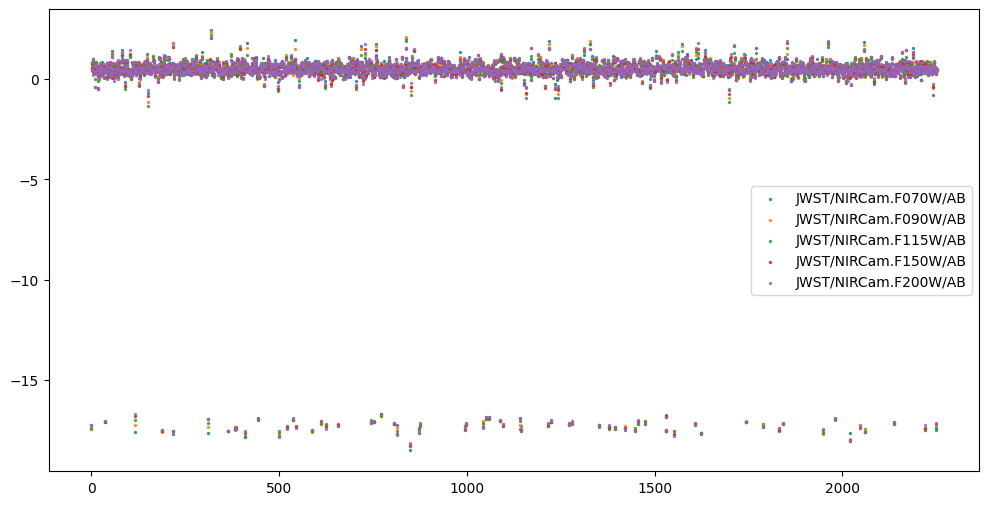

In [231]:
plt.figure(figsize=(12, 6))

residuals = (model(validation_ins) - validation_outs).detach().cpu().numpy()
for i in range(residuals.shape[-1]):
    if list(absmags.keys())[i].startswith('JWST'):
        plt.scatter(np.arange(residuals.shape[0]), residuals[:, i], label=list(absmags.keys())[i], s=2, alpha=.8)

plt.legend(loc=0);

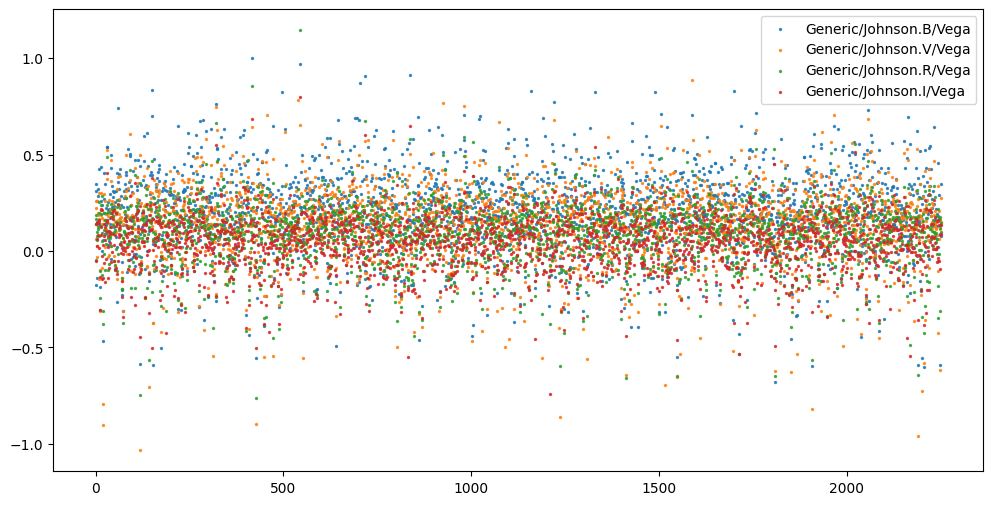

In [232]:
plt.figure(figsize=(12, 6))

residuals = (model(validation_ins) - validation_outs).detach().cpu().numpy()
for i in range(residuals.shape[-1]):
    if list(absmags.keys())[i].startswith('Generic'):
        plt.scatter(np.arange(residuals.shape[0]), residuals[:, i], label=list(absmags.keys())[i], s=2, alpha=.8)

plt.legend(loc=0);

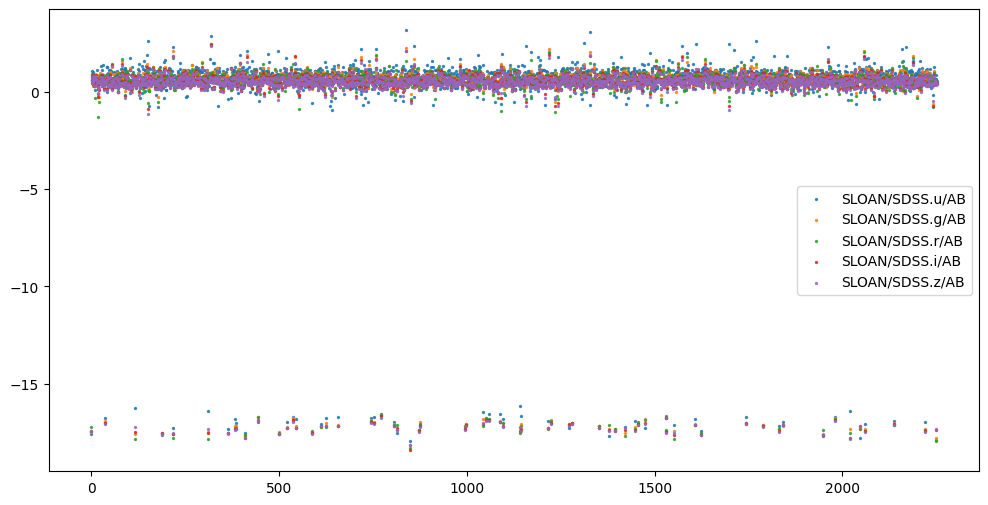

In [233]:
plt.figure(figsize=(12, 6))

residuals = (model(validation_ins) - validation_outs).detach().cpu().numpy()
for i in range(residuals.shape[-1]):
    if list(absmags.keys())[i].startswith('SLOAN'):
        plt.scatter(np.arange(residuals.shape[0]), residuals[:, i], label=list(absmags.keys())[i], s=2, alpha=.8)

plt.legend(loc=0);

It turns out the funky outliers are the unpopulated part of the grid...